In [86]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns  # 如果想要更方便地可视化混淆矩阵，可以使用 seaborn
from tqdm import tqdm   # 用于进度条
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder

In [87]:
# -----------------------------------------------------------------------------
# 1. 数据预处理函数
# -----------------------------------------------------------------------------
def preprocess_data(df):
    """
    对数据进行预处理：
    1. 将object类型或可能是字符串类型的特征进行编码（标签编码）
    2. 提取特征X和标签y
    """
    # 假设最后一列class为标签
    # 如果列名为 'class'，则：
    if 'class' not in df.columns:
        raise ValueError("DataFrame 中未找到 'class' 列，请检查数据。")
    
    #df = df.drop(columns=['id', 'attack_cat'])  # 删除无用列

    # 版本 1: Label Encoding (适合决策树、随机森林、XGBoost)
    categorical_columns = ['protocol_type', 'service', 'flag']
    df_label = df.copy()
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_label[col] = le.fit_transform(df[col])
        label_encoders[col] = le  # 存储编码器，便于逆向转换
    
    print("Label Encoding 完成...")

    # 标准化数值特征（不包括 label）
    numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
    numerical_columns.remove('class')  # 不对标签列进行标准化
    
    # 标准化方法
    scaler_standard = StandardScaler()
    scaler_minmax = MinMaxScaler()
    scaler_robust = RobustScaler()

    df_standard = df_label.copy()
    #df_minmax = df_label.copy()
    #df_robust = df_label.copy()

    df_standard[numerical_columns] = scaler_standard.fit_transform(df_standard[numerical_columns])
    
    print("标准化数值特征完成...")
    #df_minmax[numerical_columns] = scaler_minmax.fit_transform(df_minmax[numerical_columns])
    #df_robust[numerical_columns] = scaler_robust.fit_transform(df_robust[numerical_columns])

    #select_features=select_features_with_rf(df_standard, 'label')
    #df_standard=df_standard[select_features+['label']]

    # 分离特征和标签
    #X = df_standard.drop('label', axis=1)
    #y = df_standard['label']

    return df_standard

In [88]:
import torch
import torch.nn as nn
# 深度神经网络（DNN）
class DNN_IDS(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(DNN_IDS, self).__init__()
        layers = []
        layer_sizes = [input_size] + hidden_sizes + [output_size]
        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i + 1]))
            if i < len(layer_sizes) - 2:
                layers.append(nn.ReLU())
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

def create_dnn_model(input_size, hidden_sizes, output_size):
    return DNN_IDS(input_size, hidden_sizes, output_size)
# 输入大小、隐藏层大小和输出大小

In [89]:
import torch
import torch.nn as nn
# 卷积神经网络（CNN）
class CNN_IDS(nn.Module):
    def __init__(self, input_size, output_size=2):
        super(CNN_IDS, self).__init__()
        self.model = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(32),  # 归一化
            nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Flatten(),  # 展平
            nn.Linear(64 * input_size, 128),  
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout 防止过拟合
            nn.Linear(128, output_size)
        )

    def forward(self, x):
        x = x.view(x.shape[0], 1, x.shape[1])  # (batch, channels, features)
        return self.model(x)

def create_cnn_model(input_size, output_size):
    return CNN_IDS(input_size, output_size)

In [90]:
import torch
import torch.nn as nn
# 循环神经网络（RNN）
class RNN_IDS(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNN_IDS, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1, x.shape[1])  # 确保输入形状为 (batch, seq_len, input_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # 初始化 h0
        out, _ = self.rnn(x, h0)  # 前向传播
        out = self.fc(out[:, -1, :])  # 取最后时间步输出
        return out

def create_rnn_model(input_size, hidden_size, output_size, num_layers=1):
    return RNN_IDS(input_size, hidden_size, output_size, num_layers)
#input_size：每个时间步的输入特征的维度。
#hidden_size：隐藏层的大小，即 RNN 的隐状态维度。
#output_size：输出的维度，例如分类任务的类别数。
#num_layers：RNN 层数，默认值为 1。

In [91]:
import torch
import torch.nn as nn
# 长短时记忆网络（LSTM）
class LSTM_IDS(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM_IDS, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.shape[0], -1, x.shape[1])  # 确保输入形状正确 (batch, seq_len, input_size)
        
        # 纠正隐藏状态 hx 和 cx 的形状
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        out, _ = self.lstm(x, (h0, c0))  # 前向传播
        out = self.fc(out[:, -1, :])  # 取最后时间步的输出
        return out

def create_lstm_model(input_size, hidden_size, output_size, num_layers=1):
    return LSTM_IDS(input_size, hidden_size, output_size, num_layers)
#input_size：每个时间步的输入特征的维度。
#hidden_size：隐藏层的大小，即 LSTM 的隐状态维度。
#output_size：输出的维度，例如分类任务的类别数。
#num_layers：LSTM 层数，默认值为 1。


In [92]:
import torch
import torch.nn as nn

# 选择模型的函数，根据传入的模型名称返回对应的模型实例
def choose_model(model_name='dnn',input_size=None, **kwargs):
    model_name = model_name.lower()
    
    if model_name == 'dnn':  # 深度神经网络（DNN）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        hidden_sizes = kwargs.get('hidden_sizes', [128, 64])
        output_size = 2  # 入侵检测系统（IDS）是二分类任务
        return DNN_IDS(input_size, hidden_sizes, output_size)
    
    elif model_name == 'cnn':  # 卷积神经网络（CNN）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        return CNN_IDS(input_size,output_size=2)  # 二分类任务
    
    elif model_name == 'rnn':  # 循环神经网络（RNN）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        hidden_size = kwargs.get('hidden_size', 128)
        output_size = 2  # 二分类任务
        num_layers = kwargs.get('num_layers', 1)
        return RNN_IDS(input_size, hidden_size, output_size, num_layers)
    
    elif model_name == 'lstm':  # 长短时记忆网络（LSTM）
        if input_size is None:
            raise ValueError("必须提供 input_size！")
        hidden_size = kwargs.get('hidden_size', 128)
        output_size = 2  # 二分类任务
        num_layers = kwargs.get('num_layers', 1)
        return LSTM_IDS(input_size, hidden_size, output_size, num_layers)

    else:
        raise ValueError(f"Unsupported model name: {model_name}")



In [93]:
import os
# -----------------------------------------------------------------------------
# 3. 训练函数
# -----------------------------------------------------------------------------
def train_model(model, train_path, batch_size=64, epochs=10, lr=0.001):
    """
    训练给定的神经网络模型，并在每个 epoch 结束时保存训练参数。
    
    参数：
    - model: 需要训练的 PyTorch 模型
    - train_path: 训练集 CSV 文件路径
    - batch_size: 训练批次大小
    - epochs: 训练轮数
    - lr: 学习率

    返回：
    - model: 训练好的模型
    - X_train: 预处理后的训练特征（Tensor）
    - y_train: 预处理后的训练标签（Tensor）
    - select_features: 选取的特征名称列表
    """
     # 获取模型名称
    model_name = model.__class__.__name__

    # **为不同的模型创建独立的保存路径**
    SAVE_DIR = os.path.join("model_checkpoints", model_name)  # 例如：model_checkpoints/DNN/
    os.makedirs(SAVE_DIR, exist_ok=True)
    
    print(f"开始加载训练数据：{train_path}")
    df_train = pd.read_csv(train_path)

    print("开始对训练数据进行预处理...")
    
    df_train = preprocess_data(df_train)
    
    # 分离特征和标签
    X_train = df_train.drop('class', axis=1)
    y_train = df_train['class']
    #print(X_train)
    # 将 X_train 和 y_train 转换为 NumPy 数组
    X_train = X_train.to_numpy()
    y_train = y_train.to_numpy()

    # 转为 PyTorch 张量
    X_train = torch.tensor(X_train, dtype=torch.float32)
    y_train = torch.tensor(y_train, dtype=torch.long)
    

    # 选择损失函数和优化器
    criterion = nn.CrossEntropyLoss()  # 其他模型使用交叉熵损失
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # 训练循环
    print("开始训练模型...")
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        
        # 使用 tqdm 进度条
        with tqdm(total=len(X_train), desc=f"Epoch {epoch+1}/{epochs}", unit="samples") as pbar:
            # 分批次训练
            for i in range(0, len(X_train), batch_size):
                inputs = X_train[i:i+batch_size]
                labels = y_train[i:i+batch_size]

                optimizer.zero_grad()

        
      
                outputs = model(inputs)
                loss = criterion(outputs, labels)  # 其他模型使用 CrossEntropyLoss


                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                
                # 更新进度条
                pbar.update(len(inputs))

        # 计算并打印每个 epoch 的平均损失
        avg_loss = running_loss / (len(X_train) // batch_size)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")
        
        # 保存模型参数
        model_save_path = os.path.join(SAVE_DIR, f"{model.__class__.__name__}_epoch{epoch+1}.pt")
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': avg_loss
        }, model_save_path)

        print(f"模型已保存至: {model_save_path}")
        
    print("训练完成！")
    return model, X_train, y_train


In [ ]:
# -----------------------------------------------------------------------------
# 4. 测试函数
# -----------------------------------------------------------------------------
def test_model(model, test_path, batch_size=1000):
    """
    使用给定的模型和测试集路径对模型进行测试。
    返回评估指标分数，并可视化混淆矩阵。
    使用批量预测来提升速度，同时保留进度条。
    
    参数:
    - model: 训练好的模型
    - test_path: 测试集CSV文件路径
    - batch_size: 每批预测的数据量大小
    """

    print(f"开始加载测试数据：{test_path}")
    df_test = pd.read_csv(test_path)

    print("开始对测试数据进行预处理...")

    df_test = preprocess_data(df_test)
    #print(df_test.columns)
    #df_test, select_features_test= preprocess_data_select(df_test)
    #print(select_features)

    # 分离特征和标签
    X_test = df_test.drop('class', axis=1)
    y_test = df_test['class']

    #print(X_test)
    # 将 X_train 和 y_train 转换为 NumPy 数组
    X_test = X_test.to_numpy()
    y_test = y_test.to_numpy()
    
    # 转换为 PyTorch 张量
    X_test = torch.tensor(X_test, dtype=torch.float32)  # 直接传递 X_test，而不是 X_test.values
    y_test = torch.tensor(y_test, dtype=torch.long)  # 直接传递 y_test


    print("开始预测...")
    # 如果不需要进度条，或对小数据集，直接使用 model.predict(X_test) 即可:
    # y_pred = model.predict(X_test)
    #
    # 下面使用批量预测方式 + tqdm 进度条的写法：
    model.eval()  # 切换到评估模式
    predictions = []


    # 批量预测 + tqdm 进度条
    with torch.no_grad():
        with tqdm(total=len(X_test), desc="Predicting", unit="samples") as pbar:
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i+batch_size]


                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)  # 分类模型
                
                predictions.extend(predicted.numpy())

                # 更新进度条
                pbar.update(len(inputs))

    # 计算指标
    acc = accuracy_score(y_test.numpy(), predictions)
    precision = precision_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    recall = recall_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    f1 = f1_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    print(f"\n测试结果：\nAccuracy = {acc:.20f}\nPrecision = {precision:.20f}\nRecall = {recall:.20f}\nF1-Score = {f1:.20f}")
    '''
    # 可视化混淆矩阵
    cm = confusion_matrix(y_test.numpy(), predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''    
    return acc, precision, recall, f1

In [225]:
def test_model_check(model, checkpoint_path, test_path,  batch_size=1000):
    """
    使用给定的模型和测试集路径对模型进行测试。
    返回评估指标分数，并可视化混淆矩阵。
    """
    print(f"✅ 加载测试数据: {test_path}")
    df_test = pd.read_csv(test_path)
    df_test = preprocess_data(df_test)
    
    X_test = df_test.drop(columns=['class']).to_numpy()  # 只保留特征列
    y_test = df_test['class'].to_numpy()
    
    X_test = torch.tensor(X_test, dtype=torch.float32)
    y_test = torch.tensor(y_test, dtype=torch.long)
    
    print(f"✅ 加载模型参数: {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    print("🚀 开始预测...")
    predictions = []
    
        # 批量预测 + tqdm 进度条
    with torch.no_grad():
        with tqdm(total=len(X_test), desc="Predicting", unit="samples") as pbar:
            for i in range(0, len(X_test), batch_size):
                inputs = X_test[i:i+batch_size]

                outputs = model(inputs)
                _, predicted = torch.max(outputs, 1)  # 分类模型
                
                predictions.extend(predicted.numpy())

                # 更新进度条
                pbar.update(len(inputs))

    acc = accuracy_score(y_test.numpy(), predictions)
    precision = precision_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    recall = recall_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    f1 = f1_score(y_test.numpy(), predictions, average='binary', zero_division=0)
    
    print(f"\n🎯 测试结果：\nAccuracy = {acc:.4f}\nPrecision = {precision:.4f}\nRecall = {recall:.4f}\nF1-Score = {f1:.4f}")
    
    '''
    # 可视化混淆矩阵
    cm = confusion_matrix(y_test.numpy(), predictions)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    '''    
    return acc, precision, recall, f1

In [103]:
# 设置训练集路径
train_csv_path = 'NSL_KDD_train_split.csv'
df_train = pd.read_csv(train_csv_path)
df_train = preprocess_data(df_train)

input_size = len(df_train.columns) - 1  # 输入特征的大小
print(f"输入特征大小: {input_size}")

# 主流程示例
selected_model_name = 'lstm'  # 'dnn', 'cnn', 'rnn', 'lstm' 等
model = choose_model(selected_model_name, input_size=input_size)  # 选择模型

# 训练模型
model, X_train, y_train = train_model(model, train_csv_path, batch_size=64, epochs=10)

#print(select_features)

Label Encoding 完成...
标准化数值特征完成...
输入特征大小: 41
开始加载训练数据：NSL_KDD_train_split.csv
开始对训练数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始训练模型...


Epoch 1/10: 100%|██████████| 100000/100000 [00:04<00:00, 22062.80samples/s]


Epoch [1/10], Loss: 0.0747
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch1.pt


Epoch 2/10: 100%|██████████| 100000/100000 [00:04<00:00, 22188.63samples/s]


Epoch [2/10], Loss: 0.0318
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch2.pt


Epoch 3/10: 100%|██████████| 100000/100000 [00:04<00:00, 23007.34samples/s]


Epoch [3/10], Loss: 0.0261
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch3.pt


Epoch 4/10: 100%|██████████| 100000/100000 [00:04<00:00, 22746.93samples/s]


Epoch [4/10], Loss: 0.0227
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch4.pt


Epoch 5/10: 100%|██████████| 100000/100000 [00:04<00:00, 22035.19samples/s]


Epoch [5/10], Loss: 0.0205
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch5.pt


Epoch 6/10: 100%|██████████| 100000/100000 [00:05<00:00, 17558.00samples/s]


Epoch [6/10], Loss: 0.0188
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch6.pt


Epoch 7/10: 100%|██████████| 100000/100000 [00:05<00:00, 19553.51samples/s]


Epoch [7/10], Loss: 0.0175
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch7.pt


Epoch 8/10: 100%|██████████| 100000/100000 [00:04<00:00, 21721.61samples/s]


Epoch [8/10], Loss: 0.0164
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch8.pt


Epoch 9/10: 100%|██████████| 100000/100000 [00:04<00:00, 20604.97samples/s]


Epoch [9/10], Loss: 0.0154
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch9.pt


Epoch 10/10: 100%|██████████| 100000/100000 [00:04<00:00, 20038.79samples/s]

Epoch [10/10], Loss: 0.0146
模型已保存至: model_checkpoints\LSTM_IDS\LSTM_IDS_epoch10.pt
训练完成！


开始加载测试数据：NSL_KDD_test_split.csv
开始对测试数据进行预处理...
Label Encoding 完成...
标准化数值特征完成...
开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 313953.46samples/s]


测试结果：
Accuracy = 0.99179917991799182442
Precision = 0.99153478100846526022
Recall = 0.99336283185840712484
F1-Score = 0.99244796463437101597


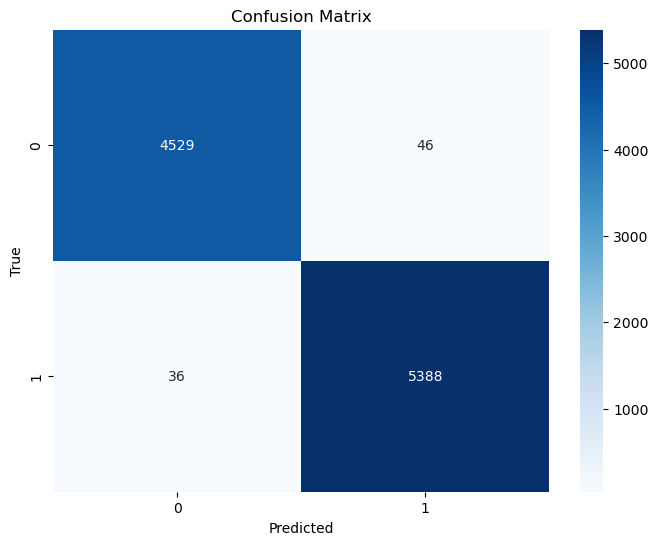

In [ ]:
# 测试模型
# 你可以调整batch_size，如1000、5000、甚至一次性预测
test_csv_path = 'NSL_KDD_test_split.csv'
#test_csv_path = 'NSL-KDD-Gaussian.csv'
#test_csv_path = 'NSL-KDD-Uniform.csv'
#test_csv_path = 'NSL-KDD-Laplace.csv'
#test_csv_path = 'NSL-KDD-Gamma.csv'
#test_csv_path = 'NSL-KDD-Poisson.csv'
#test_csv_path = 'NSL-KDD-Binomial.csv'
#test_csv_path = 'NSL-KDD-Beta.csv'
#test_csv_path = 'NSL-KDD-Cauchy.csv'

acc, precision, recall, f1 = test_model(model, test_csv_path, batch_size=1000)

✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 335033.68samples/s]


🎯 测试结果：
Accuracy = 0.5391
Precision = 0.5754
Recall = 0.5736
F1-Score = 0.5745


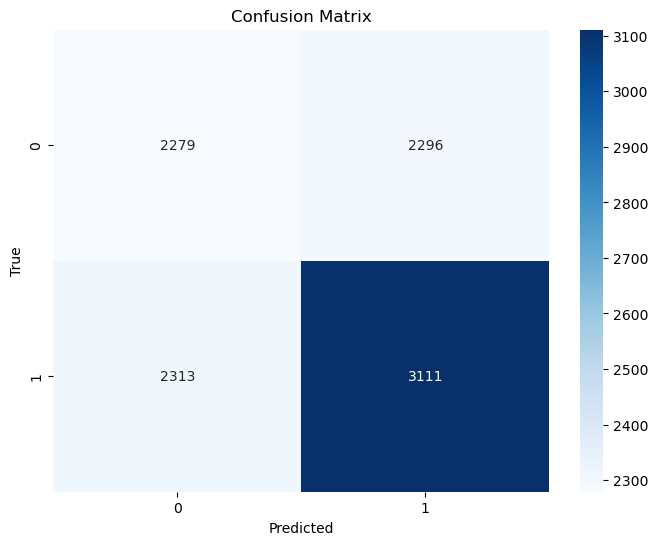

In [ ]:
model_name = 'rnn'   # 可更改为 dnn, cnn, rnn, lstm
#checkpoint_path = "model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt"
#checkpoint_path = "model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt"
checkpoint_path = "model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt"
#checkpoint_path = "model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt"
#test_csv_path = "NSL_KDD_test_split.csv"
#test_csv_path = 'NSL-KDD-Gaussian.csv'
#test_csv_path = 'NSL-KDD-Uniform.csv'
#test_csv_path = 'NSL-KDD-Laplace.csv'
test_csv_path = 'NSL-KDD-Gamma.csv'
#test_csv_path = 'NSL-KDD-Poisson.csv'
#test_csv_path = 'NSL-KDD-Binomial.csv'
#test_csv_path = 'NSL-KDD-Beta.csv'
#test_csv_path = 'NSL-KDD-Cauchy.csv'

model = choose_model(model_name, input_size=input_size)
acc, precision, recall, f1 = test_model_check(model, checkpoint_path, test_csv_path)
    

Testing model: dnn
✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1310425.12samples/s]


🎯 测试结果：
Accuracy = 0.5424
Precision = 0.5616
Recall = 0.7131
F1-Score = 0.6283


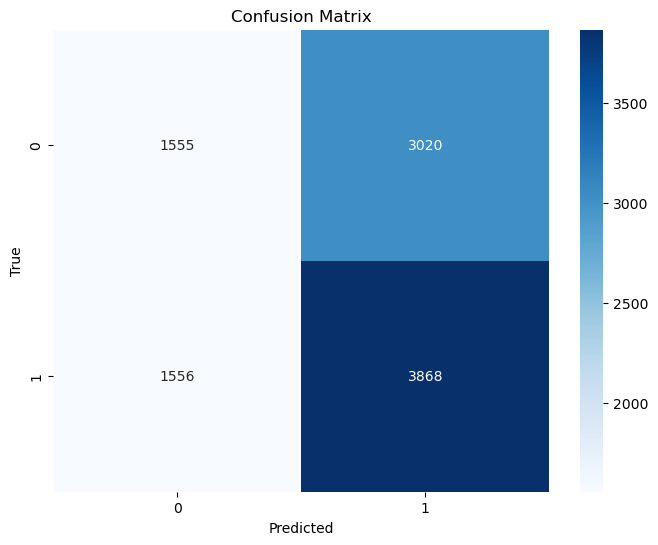

Testing model: cnn
✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 164067.80samples/s]


🎯 测试结果：
Accuracy = 0.5150
Precision = 0.5924
Recall = 0.3392
F1-Score = 0.4314


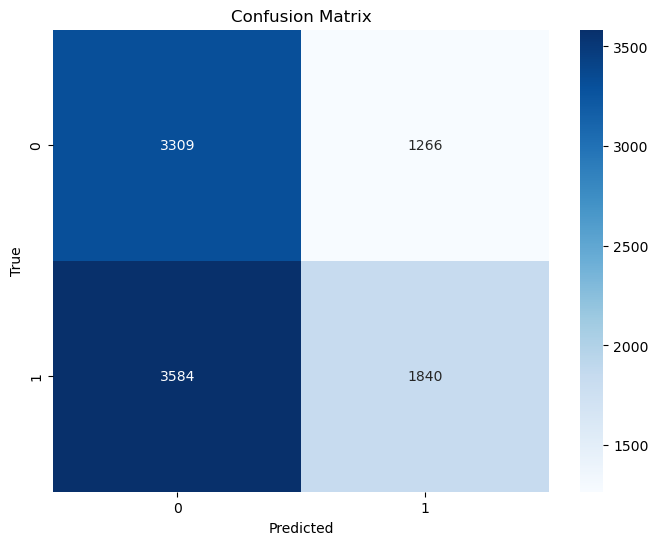

Testing model: rnn
✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 624759.35samples/s]



🎯 测试结果：
Accuracy = 0.5391
Precision = 0.5754
Recall = 0.5736
F1-Score = 0.5745


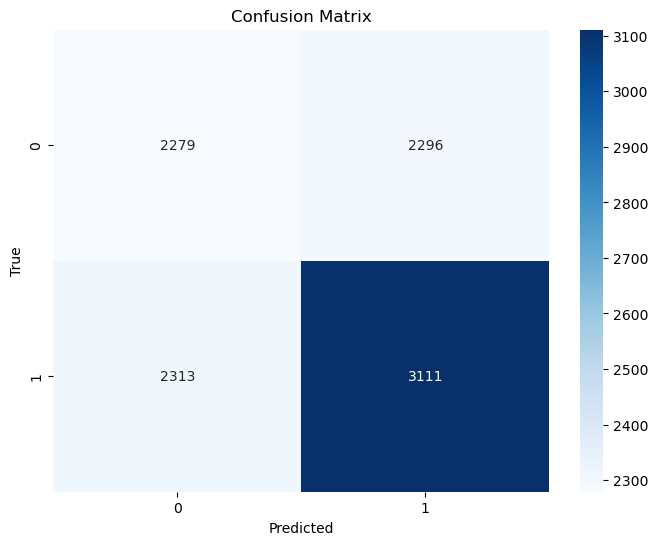

Testing model: lstm
✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 516902.02samples/s]


🎯 测试结果：
Accuracy = 0.5444
Precision = 0.5791
Recall = 0.5861
F1-Score = 0.5826


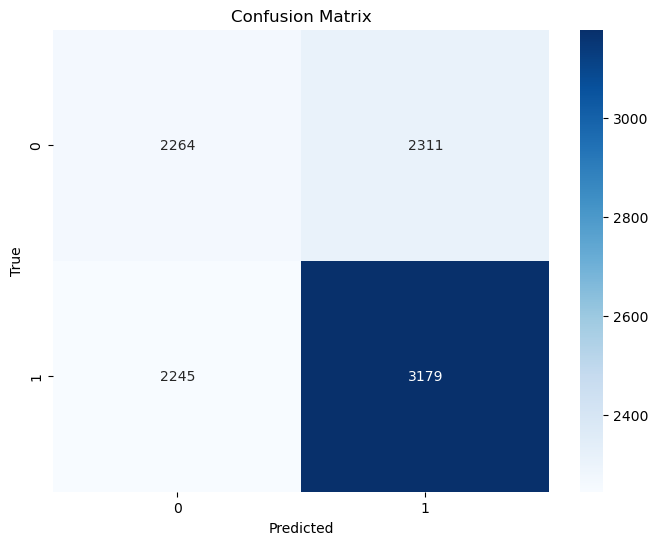


Test Results:
dnn: Accuracy=0.5424, Precision=0.5616, Recall=0.7131, F1-score=0.6283
cnn: Accuracy=0.5150, Precision=0.5924, Recall=0.3392, F1-score=0.4314
rnn: Accuracy=0.5391, Precision=0.5754, Recall=0.5736, F1-score=0.5745
lstm: Accuracy=0.5444, Precision=0.5791, Recall=0.5861, F1-score=0.5826


In [223]:
model_names = ['dnn', 'cnn', 'rnn', 'lstm']  # 可更改或扩展模型列表

 # 统一测试数据集路径
#test_csv_path = "NSL_KDD_test_split.csv"
#test_csv_path = 'NSL-KDD-Gaussian.csv'
#test_csv_path = 'NSL-KDD-Uniform.csv'
test_csv_path = 'NSL-KDD-Laplace.csv'
#test_csv_path = 'NSL-KDD-Gamma.csv'
#test_csv_path = 'NSL-KDD-Poisson.csv'
#test_csv_path = 'NSL-KDD-Binomial.csv'
#test_csv_path = 'NSL-KDD-Beta.csv'
#test_csv_path = 'NSL-KDD-Cauchy.csv'
    
results = []
    
for model_name in model_names:
    print(f"Testing model: {model_name}")
        
    # 选择模型
    model = choose_model(model_name, input_size=input_size)
        
    # 选择对应的 checkpoint 路径
    checkpoint_path = f"model_checkpoints/{model_name.upper()}_IDS/{model_name.upper()}_IDS_epoch10.pt"
        
    # 进行测试
    acc, precision, recall, f1 = test_model_check(model, checkpoint_path, test_csv_path)
    results.append((model_name, acc, precision, recall, f1))
    
    # 打印测试结果
print("\nTest Results:")
for model_name, acc, precision, recall, f1 in results:
    print(f"{model_name}: Accuracy={acc:.4f}, Precision={precision:.4f}, Recall={recall:.4f}, F1-score={f1:.4f}")

In [226]:
model_names = ['dnn', 'cnn', 'rnn', 'lstm']  # 可更改或扩展模型列表
test_files = [
        "NSL_KDD_test_split.csv",
        'NSL-KDD-Gaussian.csv', 
        'NSL-KDD-Uniform.csv', 
        'NSL-KDD-Laplace.csv',
        'NSL-KDD-Gamma.csv', 
        'NSL-KDD-Poisson.csv', 
        'NSL-KDD-Binomial.csv',
        'NSL-KDD-Beta.csv', 
        'NSL-KDD-Cauchy.csv'
    ]
    
results = []
    
for model_name in model_names:
        print(f"Testing model: {model_name}")
        
        # 选择模型
        model = choose_model(model_name, input_size=input_size)
        
        # 遍历所有测试文件
        for test_csv_path in test_files:
            print(f"Testing model {model_name} on {test_csv_path}")
            
            # 选择对应的 checkpoint 路径
            checkpoint_path = f"model_checkpoints/{model_name.upper()}_IDS/{model_name.upper()}_IDS_epoch10.pt"
            
            # 进行测试
            acc, precision, recall, f1 = test_model_check(model, checkpoint_path, test_csv_path)
            results.append((model_name, test_csv_path, acc, precision, recall, f1))
    
    # 保存结果到 CSV 文件
results_df = pd.DataFrame(results, columns=['Model', 'Test File', 'Accuracy', 'Precision', 'Recall', 'F1-score'])
results_df.to_csv('model_test_results-dp.csv', index=False)
    
# 打印测试结果
print("\nTest Results:")
print(results_df)

Testing model: dnn
Testing model dnn on NSL_KDD_test_split.csv
✅ 加载测试数据: NSL_KDD_test_split.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 522329.07samples/s]



🎯 测试结果：
Accuracy = 0.9912
Precision = 0.9904
Recall = 0.9934
F1-Score = 0.9919
Testing model dnn on NSL-KDD-Gaussian.csv
✅ 加载测试数据: NSL-KDD-Gaussian.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1020856.96samples/s]


🎯 测试结果：
Accuracy = 0.5386
Precision = 0.5584
Recall = 0.7140
F1-Score = 0.6267
Testing model dnn on NSL-KDD-Uniform.csv
✅ 加载测试数据: NSL-KDD-Uniform.csv


Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1110992.23samples/s]



🎯 测试结果：
Accuracy = 0.5323
Precision = 0.5544
Recall = 0.7017
F1-Score = 0.6194
Testing model dnn on NSL-KDD-Laplace.csv
✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<?, ?samples/s]


🎯 测试结果：
Accuracy = 0.5424
Precision = 0.5616
Recall = 0.7131
F1-Score = 0.6283


Testing model dnn on NSL-KDD-Gamma.csv
✅ 加载测试数据: NSL-KDD-Gamma.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1217665.81samples/s]



🎯 测试结果：
Accuracy = 0.5972
Precision = 0.5994
Recall = 0.7758
F1-Score = 0.6763
Testing model dnn on NSL-KDD-Poisson.csv
✅ 加载测试数据: NSL-KDD-Poisson.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1581583.35samples/s]



🎯 测试结果：
Accuracy = 0.6582
Precision = 0.6463
Recall = 0.8169
F1-Score = 0.7217
Testing model dnn on NSL-KDD-Binomial.csv
✅ 加载测试数据: NSL-KDD-Binomial.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1260787.81samples/s]



🎯 测试结果：
Accuracy = 0.8736
Precision = 0.8481
Recall = 0.9344
F1-Score = 0.8891
Testing model dnn on NSL-KDD-Beta.csv
✅ 加载测试数据: NSL-KDD-Beta.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1630846.39samples/s]


🎯 测试结果：
Accuracy = 0.8799
Precision = 0.9159
Recall = 0.8573
F1-Score = 0.8856


Testing model dnn on NSL-KDD-Cauchy.csv
✅ 加载测试数据: NSL-KDD-Cauchy.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/DNN_IDS/DNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 1425957.83samples/s]



🎯 测试结果：
Accuracy = 0.5958
Precision = 0.5796
Recall = 0.9274
F1-Score = 0.7134
Testing model: cnn
Testing model cnn on NSL_KDD_test_split.csv
✅ 加载测试数据: NSL_KDD_test_split.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 179266.44samples/s]


🎯 测试结果：
Accuracy = 0.9936
Precision = 0.9925
Recall = 0.9958
F1-Score = 0.9941
Testing model cnn on NSL-KDD-Gaussian.csv
✅ 加载测试数据: NSL-KDD-Gaussian.csv
Label Encoding 完成...


标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 154043.08samples/s]



🎯 测试结果：
Accuracy = 0.5092
Precision = 0.5780
Recall = 0.3525
F1-Score = 0.4379
Testing model cnn on NSL-KDD-Uniform.csv
✅ 加载测试数据: NSL-KDD-Uniform.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 164194.34samples/s]



🎯 测试结果：
Accuracy = 0.4993
Precision = 0.5590
Recall = 0.3652
F1-Score = 0.4418
Testing model cnn on NSL-KDD-Laplace.csv
✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 184046.44samples/s]



🎯 测试结果：
Accuracy = 0.5150
Precision = 0.5924
Recall = 0.3392
F1-Score = 0.4314
Testing model cnn on NSL-KDD-Gamma.csv
✅ 加载测试数据: NSL-KDD-Gamma.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 123730.20samples/s]



🎯 测试结果：
Accuracy = 0.5890
Precision = 0.6563
Recall = 0.5087
F1-Score = 0.5731
Testing model cnn on NSL-KDD-Poisson.csv
✅ 加载测试数据: NSL-KDD-Poisson.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 178666.93samples/s]



🎯 测试结果：
Accuracy = 0.6266
Precision = 0.7194
Recall = 0.5109
F1-Score = 0.5975
Testing model cnn on NSL-KDD-Binomial.csv
✅ 加载测试数据: NSL-KDD-Binomial.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 137104.34samples/s]



🎯 测试结果：
Accuracy = 0.8068
Precision = 0.9230
Recall = 0.7024
F1-Score = 0.7977
Testing model cnn on NSL-KDD-Beta.csv
✅ 加载测试数据: NSL-KDD-Beta.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 185815.95samples/s]



🎯 测试结果：
Accuracy = 0.8862
Precision = 0.9837
Recall = 0.8035
F1-Score = 0.8845
Testing model cnn on NSL-KDD-Cauchy.csv
✅ 加载测试数据: NSL-KDD-Cauchy.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/CNN_IDS/CNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 154482.84samples/s]



🎯 测试结果：
Accuracy = 0.5211
Precision = 0.5467
Recall = 0.6853
F1-Score = 0.6082
Testing model: rnn
Testing model rnn on NSL_KDD_test_split.csv
✅ 加载测试数据: NSL_KDD_test_split.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 728952.87samples/s]


🎯 测试结果：
Accuracy = 0.9916
Precision = 0.9932
Recall = 0.9913
F1-Score = 0.9922
Testing model rnn on NSL-KDD-Gaussian.csv
✅ 加载测试数据: NSL-KDD-Gaussian.csv
Label Encoding 完成...


标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 804381.56samples/s]



🎯 测试结果：
Accuracy = 0.5317
Precision = 0.5675
Recall = 0.5741
F1-Score = 0.5708
Testing model rnn on NSL-KDD-Uniform.csv
✅ 加载测试数据: NSL-KDD-Uniform.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 772724.43samples/s]



🎯 测试结果：
Accuracy = 0.5304
Precision = 0.5669
Recall = 0.5684
F1-Score = 0.5677
Testing model rnn on NSL-KDD-Laplace.csv
✅ 加载测试数据: NSL-KDD-Laplace.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 559684.59samples/s]



🎯 测试结果：
Accuracy = 0.5391
Precision = 0.5754
Recall = 0.5736
F1-Score = 0.5745
Testing model rnn on NSL-KDD-Gamma.csv
✅ 加载测试数据: NSL-KDD-Gamma.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 511980.05samples/s]



🎯 测试结果：
Accuracy = 0.5897
Precision = 0.6209
Recall = 0.6256
F1-Score = 0.6232
Testing model rnn on NSL-KDD-Poisson.csv
✅ 加载测试数据: NSL-KDD-Poisson.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 998995.87samples/s]



🎯 测试结果：
Accuracy = 0.6617
Precision = 0.6817
Recall = 0.7058
F1-Score = 0.6935
Testing model rnn on NSL-KDD-Binomial.csv
✅ 加载测试数据: NSL-KDD-Binomial.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 703943.56samples/s]



🎯 测试结果：
Accuracy = 0.8942
Precision = 0.9026
Recall = 0.9023
F1-Score = 0.9025
Testing model rnn on NSL-KDD-Beta.csv
✅ 加载测试数据: NSL-KDD-Beta.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 730616.45samples/s]



🎯 测试结果：
Accuracy = 0.8106
Precision = 0.8809
Recall = 0.7526
F1-Score = 0.8117
Testing model rnn on NSL-KDD-Cauchy.csv
✅ 加载测试数据: NSL-KDD-Cauchy.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/RNN_IDS/RNN_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 966778.37samples/s]


🎯 测试结果：
Accuracy = 0.6574
Precision = 0.6346
Recall = 0.8682
F1-Score = 0.7333


Testing model: lstm
Testing model lstm on NSL_KDD_test_split.csv
✅ 加载测试数据: NSL_KDD_test_split.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 997261.75samples/s]



🎯 测试结果：
Accuracy = 0.9918
Precision = 0.9915
Recall = 0.9934
F1-Score = 0.9924
Testing model lstm on NSL-KDD-Gaussian.csv
✅ 加载测试数据: NSL-KDD-Gaussian.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 584366.93samples/s]



🎯 测试结果：
Accuracy = 0.5404
Precision = 0.5751
Recall = 0.5848
F1-Score = 0.5799
Testing model lstm on NSL-KDD-Uniform.csv
✅ 加载测试数据: NSL-KDD-Uniform.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 473110.11samples/s]


🎯 测试结果：
Accuracy = 0.5304
Precision = 0.5668
Recall = 0.5697
F1-Score = 0.5682
Testing model lstm on NSL-KDD-Laplace.csv
✅ 加载测试数据: NSL-KDD-Laplace.csv


Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 493857.18samples/s]



🎯 测试结果：
Accuracy = 0.5444
Precision = 0.5791
Recall = 0.5861
F1-Score = 0.5826
Testing model lstm on NSL-KDD-Gamma.csv
✅ 加载测试数据: NSL-KDD-Gamma.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 654966.98samples/s]


🎯 测试结果：
Accuracy = 0.6007
Precision = 0.6285
Recall = 0.6451
F1-Score = 0.6367


Testing model lstm on NSL-KDD-Poisson.csv
✅ 加载测试数据: NSL-KDD-Poisson.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 554665.93samples/s]



🎯 测试结果：
Accuracy = 0.6805
Precision = 0.6923
Recall = 0.7399
F1-Score = 0.7153
Testing model lstm on NSL-KDD-Binomial.csv
✅ 加载测试数据: NSL-KDD-Binomial.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 489522.32samples/s]



🎯 测试结果：
Accuracy = 0.8996
Precision = 0.9064
Recall = 0.9087
F1-Score = 0.9076
Testing model lstm on NSL-KDD-Beta.csv
✅ 加载测试数据: NSL-KDD-Beta.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 526770.65samples/s]


🎯 测试结果：
Accuracy = 0.8444
Precision = 0.9284
Recall = 0.7727
F1-Score = 0.8434


Testing model lstm on NSL-KDD-Cauchy.csv
✅ 加载测试数据: NSL-KDD-Cauchy.csv
Label Encoding 完成...
标准化数值特征完成...
✅ 加载模型参数: model_checkpoints/LSTM_IDS/LSTM_IDS_epoch10.pt
🚀 开始预测...


Predicting: 100%|██████████| 9999/9999 [00:00<00:00, 415602.32samples/s]


🎯 测试结果：
Accuracy = 0.6759
Precision = 0.6423
Recall = 0.9084
F1-Score = 0.7525

Test Results:
   Model               Test File  Accuracy  Precision    Recall  F1-score
0    dnn  NSL_KDD_test_split.csv  0.991199   0.990441  0.993363  0.991900
1    dnn    NSL-KDD-Gaussian.csv  0.538554   0.558391  0.714049  0.626699
2    dnn     NSL-KDD-Uniform.csv  0.532253   0.554406  0.701696  0.619416
3    dnn     NSL-KDD-Laplace.csv  0.542354   0.561556  0.713127  0.628330
4    dnn       NSL-KDD-Gamma.csv  0.597160   0.599430  0.775811  0.676310
5    dnn     NSL-KDD-Poisson.csv  0.658166   0.646295  0.816925  0.721661
6    dnn    NSL-KDD-Binomial.csv  0.873587   0.848059  0.934366  0.889123
7    dnn        NSL-KDD-Beta.csv  0.879888   0.915895  0.857301  0.885630
8    dnn      NSL-KDD-Cauchy.csv  0.595760   0.579627  0.927360  0.713374
9    cnn  NSL_KDD_test_split.csv  0.993599   0.992466  0.995760  0.994110
10   cnn    NSL-KDD-Gaussian.csv  0.509151   0.577993  0.352507  0.437929
11   cnn     NSL-